In [1]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
nltk.download('punkt')

import string
from textblob import TextBlob
from textblob import Word
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

import re

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/kaggle/input/amazon-books-reviews/books_data.csv
/kaggle/input/amazon-books-reviews/Books_rating.csv


In [2]:
dataset_path = '/kaggle/input/amazon-books-reviews/Books_rating.csv'
df = pd.read_csv(dataset_path)
print(f"df.shape: {df.shape}")
pd.set_option("display.max_colwidth", 240)
df.head()

df.shape: (3000000, 10)


,Id,Title,Price,User_id,profileName,review/helpfulness,review/score,review/time,review/summary,review/text
0,1882931173,Its Only Art If Its Well Hung!,NaN,AVCGYZL8FQQTD,"Jim of Oz ""jim-of-oz""",7/7,4.0,940636800,Nice collection of Julie Strain images,"This is only for Julie Strain fans. It's a collection of her photos -- about 80 pages worth with a nice section of paintings by Olivia.If you're looking for heavy literary content, this isn't the place to find it -- there's only about 2..."
1,0826414346,Dr. Seuss: American Icon,NaN,A30TK6U7DNS82R,Kevin Killian,10/10,5.0,1095724800,Really Enjoyed It,I don't care much for Dr. Seuss but after reading Philip Nel's book I changed my mind--that's a good testimonial to the power of Rel's writing and thinking. Rel plays Dr. Seuss the ultimate compliment of treating him as a serious poet a...
2,0826414346,Dr. Seuss: American Icon,NaN,A3UH4UZ4RSVO82,John Granger,10/11,5.0,1078790400,Essential for every personal and Public Library,"If people become the books they read and if ""the child is father to the man,"" then Dr. Seuss (Theodor Seuss Geisel) is the most influential author, poet, and artist of modern times. For me, a daddy to a large family who learned to read ..."
3,0826414346,Dr. Seuss: American Icon,NaN,A2MVUWT453QH61,"Roy E. Perry ""amateur philosopher""",7/7,4.0,1090713600,Phlip Nel gives silly Seuss a serious treatment,"Theodore Seuss Geisel (1904-1991), aka &quot;Dr. Seuss,&quot; was one of the most influential writers and artists of the 20th century.In 1959, Rudolf Flesch wrote, &quot;A hundred years from now, children and their parents will still ea..."
4,0826414346,Dr. Seuss: American Icon,NaN,A22X4XUPKF66MR,"D. H. Richards ""ninthwavestore""",3/3,4.0,1107993600,Good academic overview,"Philip Nel - Dr. Seuss: American IconThis is basically an academic overview of Seuss poetry, art, cartoons, and the problems with the commercialization of the Seuss name and works after his death. It is not, to any real extent, a biogra..."


In [3]:
df['Title'].value_counts()
df = df[df.groupby("Title")['Title'].transform("size") > 20]
df = df.head(50000)

In [4]:
columns_to_keep = ['Id','Title','review/score','review/text']
df = df[columns_to_keep]
df.head()

,Id,Title,review/score,review/text
14,0595344550,Whispers of the Wicked Saints,1.0,"I bought this book because I read some glowing praise on an online library site. Unfortunately, I was deeply disappointed by page three. I always buy books in the hope and expectation of having an enjoyable read, not to criticise. Howev..."
15,0595344550,Whispers of the Wicked Saints,4.0,"I have to admit, I am not one to write reviews on book. I do however like to read them. Some of the reviews are great, some are cruel, but the reviews on this book were absolutlely hysterical. I read this book and after watching the war..."
16,0595344550,Whispers of the Wicked Saints,1.0,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I..."
17,0595344550,Whispers of the Wicked Saints,5.0,When I first read this the I was mezmerized at the style of writting. I soon became so hooked on this book that I wanted to fall on my knees and shut out the rest of the world. Haddon delivers a portrayal of a woman that is hurt loney a...
18,0595344550,Whispers of the Wicked Saints,5.0,I read the review directly under mine and I have to say I laughed. How can someone write a honest review on a book they read only three pages of? That was funny but also sad that people are mean enough to keep others from an enjoyable r...


In [5]:

df['review/text'] = df['review/text'].astype(str)
df = df[~df['review/text'].isnull()]
len(df)

df['review1'] = df['review/text'].apply(lambda x: " ".join(x.lower() for x in x.split()))

def remove_punctuation(text):
    return re.sub(r'[^\w\s]', '', text)

df['review1'] = df['review1'].apply(remove_punctuation)

stop = stopwords.words('english')
df['review1'] = df['review1'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

df.head()

,Id,Title,review/score,review/text,review1
14,0595344550,Whispers of the Wicked Saints,1.0,"I bought this book because I read some glowing praise on an online library site. Unfortunately, I was deeply disappointed by page three. I always buy books in the hope and expectation of having an enjoyable read, not to criticise. Howev...",bought book read glowing praise online library site unfortunately deeply disappointed page three always buy books hope expectation enjoyable read criticise however book urgent need good editing though quite possibly editing alone wouldn...
15,0595344550,Whispers of the Wicked Saints,4.0,"I have to admit, I am not one to write reviews on book. I do however like to read them. Some of the reviews are great, some are cruel, but the reviews on this book were absolutlely hysterical. I read this book and after watching the war...",admit one write reviews book however like read reviews great cruel reviews book absolutlely hysterical read book watching war words couldnt help jump good side book loved kept intersted bad side say typo featured back cover secret likin...
16,0595344550,Whispers of the Wicked Saints,1.0,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I...",selfpublished book want know whyread paragraphs 5 star reviews must written ms haddons family friendsor perhaps cant imagine anyone reading whole thingi spent evening book friend hysterics reading bits pieces one another definitely bad ...
17,0595344550,Whispers of the Wicked Saints,5.0,When I first read this the I was mezmerized at the style of writting. I soon became so hooked on this book that I wanted to fall on my knees and shut out the rest of the world. Haddon delivers a portrayal of a woman that is hurt loney a...,first read mezmerized style writting soon became hooked book wanted fall knees shut rest world haddon delivers portrayal woman hurt loney abused think wonderful job making reader feel like character
18,0595344550,Whispers of the Wicked Saints,5.0,I read the review directly under mine and I have to say I laughed. How can someone write a honest review on a book they read only three pages of? That was funny but also sad that people are mean enough to keep others from an enjoyable r...,read review directly mine say laughed someone write honest review book read three pages funny also sad people mean enough keep others enjoyable read loved book thought first chapter little long read whole book loved book afair heart rig...


In [6]:
df['polarity'] = df['review1'].map(lambda text: TextBlob(text).sentiment.polarity)

def categorize_polarity(score):
    if score < -0.1:
        return 'negative'
    elif score > 0.1:
        return 'positive'
    else:
        return 'neutral'
df['sentiment'] = df['polarity'].apply(categorize_polarity)

df.head()

,Id,Title,review/score,review/text,review1,polarity,sentiment
14,0595344550,Whispers of the Wicked Saints,1.0,"I bought this book because I read some glowing praise on an online library site. Unfortunately, I was deeply disappointed by page three. I always buy books in the hope and expectation of having an enjoyable read, not to criticise. Howev...",bought book read glowing praise online library site unfortunately deeply disappointed page three always buy books hope expectation enjoyable read criticise however book urgent need good editing though quite possibly editing alone wouldn...,0.025595,neutral
15,0595344550,Whispers of the Wicked Saints,4.0,"I have to admit, I am not one to write reviews on book. I do however like to read them. Some of the reviews are great, some are cruel, but the reviews on this book were absolutlely hysterical. I read this book and after watching the war...",admit one write reviews book however like read reviews great cruel reviews book absolutlely hysterical read book watching war words couldnt help jump good side book loved kept intersted bad side say typo featured back cover secret likin...,-0.062500,neutral
16,0595344550,Whispers of the Wicked Saints,1.0,"This is a self-published book, and if you want to know why--read a few paragraphs! Those 5 star reviews must have been written by Ms. Haddon's family and friends--or perhaps, by herself! I can't imagine anyone reading the whole thing--I...",selfpublished book want know whyread paragraphs 5 star reviews must written ms haddons family friendsor perhaps cant imagine anyone reading whole thingi spent evening book friend hysterics reading bits pieces one another definitely bad ...,0.030000,neutral
17,0595344550,Whispers of the Wicked Saints,5.0,When I first read this the I was mezmerized at the style of writting. I soon became so hooked on this book that I wanted to fall on my knees and shut out the rest of the world. Haddon delivers a portrayal of a woman that is hurt loney a...,first read mezmerized style writting soon became hooked book wanted fall knees shut rest world haddon delivers portrayal woman hurt loney abused think wonderful job making reader feel like character,0.625000,positive
18,0595344550,Whispers of the Wicked Saints,5.0,I read the review directly under mine and I have to say I laughed. How can someone write a honest review on a book they read only three pages of? That was funny but also sad that people are mean enough to keep others from an enjoyable r...,read review directly mine say laughed someone write honest review book read three pages funny also sad people mean enough keep others enjoyable read loved book thought first chapter little long read whole book loved book afair heart rig...,0.299320,positive


In [7]:
df.sentiment.value_counts(normalize=True)

sentiment
positive    0.69346
neutral     0.26102
negative    0.04552
Name: proportion, dtype: float64

In [8]:
X = df['review/text'].copy()
y = df['sentiment'].copy()

X_train_raw, X_val_raw, y_train, y_val = train_test_split(X, y, test_size=0.20, random_state=42)

In [9]:

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(X_train_raw).toarray()
print(f"X_train.shape = {X_train.shape}")
type(X_train)

X_train.shape = (40000, 77076)


numpy.ndarray

In [10]:
model = RandomForestClassifier(n_estimators=25)
model = model.fit(X_train, y_train)

In [11]:
sums = np.sum(X_train, axis=0)
sorted_indices = np.argsort(sums)[::-1]
N = 1000
top_n_indices = sorted_indices[:N]

feature_names = np.array(tfidf_vectorizer.get_feature_names_out())
top_n_feature_names = feature_names[top_n_indices]

tfidf_vectorizer_top_n = TfidfVectorizer(vocabulary=top_n_feature_names)

X_train_reduced = tfidf_vectorizer_top_n.fit_transform(X_train_raw).toarray()
X_val_reduced = tfidf_vectorizer_top_n.transform(X_val_raw).toarray()
model.fit(X_train_reduced, y_train)


RandomForestClassifier(n_estimators=25)

accuracy (on y_train): 0.9992


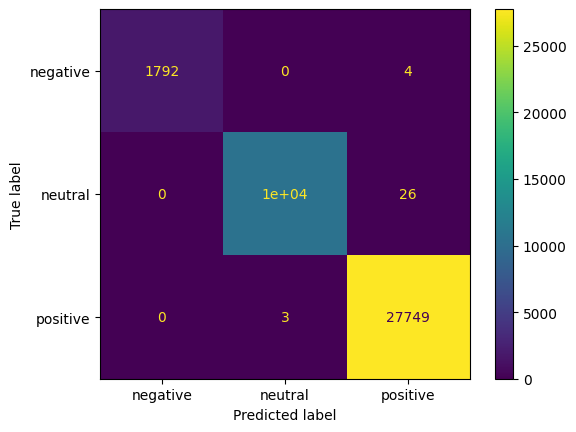

In [12]:
predictions_train = model.predict(X_train_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix(y_train, predictions_train), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on y_train): {accuracy_score(y_train, predictions_train):.4f}")

accuracy (on y_val): 0.7730


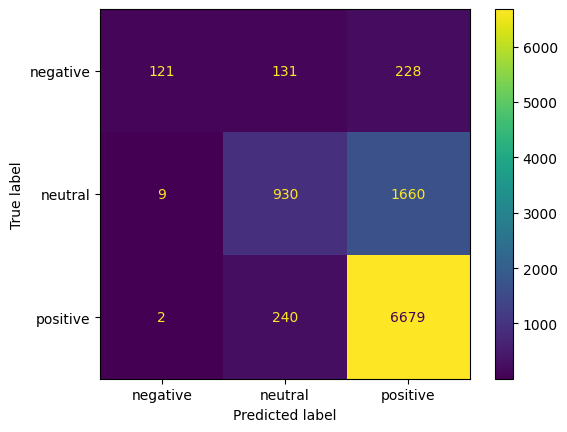

In [13]:
predictions_val = model.predict(X_val_reduced)
disp = ConfusionMatrixDisplay(confusion_matrix(y_val, predictions_val), display_labels=['negative', 'neutral', 'positive'])
disp.plot()
print(f"accuracy (on y_val): {accuracy_score(y_val, predictions_val):.4f}")

In [14]:
from sklearn.metrics import log_loss

# A function to create and fit a RF with a specific number
def tuneModel(hyperparam_value):
    rf_model = RandomForestClassifier(n_estimators=hyperparam_value, random_state=5)
    rf_model.fit(X_train_reduced, y_train)
    y_train_pred_prob = rf_model.predict_proba(X_train_reduced)
    y_train_pred = rf_model.predict(X_train_reduced)
    y_val_pred_prob = rf_model.predict_proba(X_val_reduced)
    y_val_pred = rf_model.predict(X_val_reduced)
    train_loss = log_loss(y_train, y_train_pred_prob, labels=['negative', 'neutral', 'positive'])
    train_acc = accuracy_score(y_train, y_train_pred)
    val_loss = log_loss(y_val, y_val_pred_prob, labels=['negative', 'neutral', 'positive'])
    val_acc = accuracy_score(y_val, y_val_pred)
    return (train_loss, val_loss, train_acc, val_acc)

hyp_param_vals = list(range(10,261,50)) # good values for n_estimators

metrics = []

for hp in hyp_param_vals:
    metrics.append(tuneModel(hp))

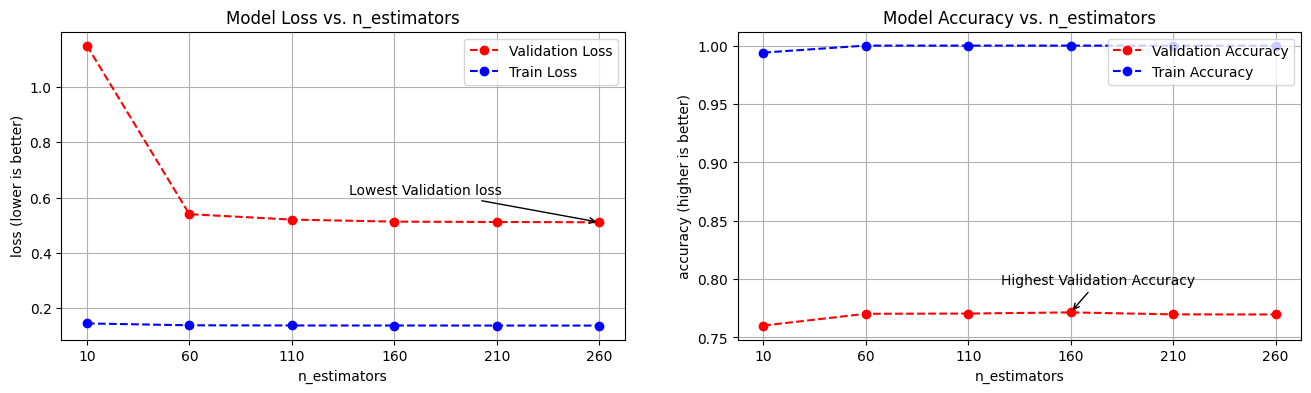

In [15]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.set_xticks(hyp_param_vals)
ax1.set(xlabel="n_estimators", ylabel="loss (lower is better)")
ax1.plot(hyp_param_vals, [metric[1] for metric in metrics], '--ro') # validation loss
ax1.plot(hyp_param_vals, [metric[0] for metric in metrics], '--bo') # training loss
ax1.set_title("Model Loss vs. n_estimators")
ax1.grid(True)

ax2.set_xticks(hyp_param_vals)
ax2.set(xlabel="n_estimators", ylabel="accuracy (higher is better)")
ax2.plot(hyp_param_vals, [metric[3] for metric in metrics], '--ro') # validation accuracy
ax2.plot(hyp_param_vals, [metric[2] for metric in metrics], '--bo') # training accuracy
ax2.set_title("Model Accuracy vs. n_estimators")
ax2.grid(True)
    
min_val_loss = min([metric[1] for metric in metrics])
min_val_loss_index = [metric[1] for metric in metrics].index(min_val_loss)
ax1.annotate('Lowest Validation loss', 
             xy=(hyp_param_vals[min_val_loss_index], min_val_loss),
             xytext=(-180, 20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))
max_val_acc = max([metric[3] for metric in metrics])
max_val_acc_index = [metric[3] for metric in metrics].index(max_val_acc)
ax2.annotate("Highest Validation Accuracy",
             xy=(hyp_param_vals[max_val_acc_index], max_val_acc),
             xytext=(-50, 20),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', color='black'))
    
ax1.legend(["Validation Loss", "Train Loss"], loc=1)
ax2.legend(["Validation Accuracy", "Train Accuracy"], loc=1)
    
plt.show()

In [16]:
tuning_results = np.array([hyp_param_vals, [round(metric[1],2) for metric in metrics], [round(metric[3],2) for metric in metrics]])
df_tuning_results = pd.DataFrame({'hyperparam':hyp_param_vals, 'test_loss':[metric[1] for metric in metrics], 'test_acc':[metric[3] for metric in metrics]})
print(df_tuning_results)

   hyperparam  test_loss  test_acc
0          10   1.149205    0.7602
1          60   0.539839    0.7703
2         110   0.520285    0.7705
3         160   0.512964    0.7715
4         210   0.511685    0.7698
5         260   0.510623    0.7697
